# Minimax approximate polynomial for homomorphic comparison

Approximation function?


In [1]:
import numpy as np
import math
from math import sqrt, ceil
from numpy import polynomial as P
import matplotlib.pyplot as plt 

from hemul.cipher import *
from hemul.ciphertext import Plaintext
from hemul.scheme import *
from hemul.algorithms import Algorithms 
from hemul.stats import Statistics
from hemul.context import set_all

from hemul.comparator import appr_sign, appr_relu

In [2]:
def relu(arr):
    _arr = arr.copy()
    _arr[_arr<0]=0
    return _arr

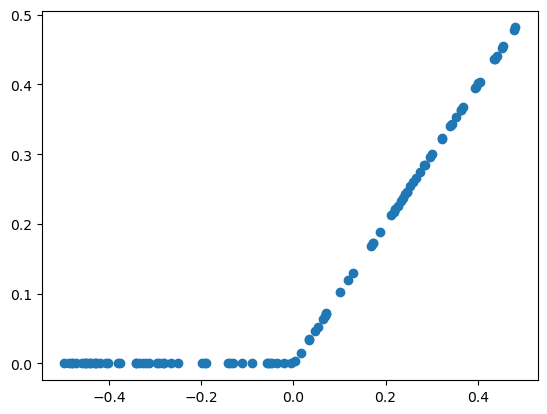

In [3]:
arr = np.random.rand(100) - 0.5
plt.scatter(arr, relu(arr))

In [4]:
# Ordinary funcitons
def get_depth(degree:int):
    if degree > 1:
        return ceil(np.log2(degree))
    elif degree == 1:
        return 0

In [5]:
# degrees from i=1 to k
# from Eunsang Lee+21
MINIMUM_MULT = {4:[3,3,5],
                5:[5,5,5],
                6:[3,5,5,5],
                7:[3,3,5,5,5],
                8:[5,5,5,5,9],
                9:[5,5,5,5,5,5],
               10:[5,5,5,5,5,9],
               11:[3,5,5,5,5,5,5],
               12:[3,5,5,5,5,5,9],
               13:[3,5,5,5,5,5,5,5],
               14:[3,3,5,5,5,5,5,5,5],
               15:[3,3,5,5,5,5,5,5,9],
               16:[3,3,5,5,5,5,5,5,5,5],
               17:[5,5,5,5,5,5,5,5,5,5],
               18:[3,3,5,5,5,5,5,5,5,5,5],
               19:[5,5,5,5,5,5,5,5,5,5,5],
               20:[5,5,5,5,5,5,5,5,5,5,9]}

MINIMUM_DEPTH = {4:[27],
                 5:[7,13],
                 6:[15,15],
                 7:[7,7,13],
                 8:[7,15,15],
                 9:[7,7,7,13],
                10:[7,7,13,15],
                11:[7,15,15,15],
                12:[15,15,15,15],
                13:[15,15,15,31],
                14:[7,7,15,15,27],
                15:[7,15,15,15,27],
                16:[15,15,15,15,27],
                17:[15,15,15,29,29],
                18:[15,15,29,29,31],
                19:[15,29,31,31,31],
                20:[29,31,31,31,31]}

def poly_eval(ctxt, coeff):
    """Evaluate polynomial expression of coefficients "coeff"
    
    parameters
    ----------
    ctxt: Ciphertext
    coeff: Coefficients of polynomial starting from 0-th degree
    
    
    exmaple
    -------
        y = ax + bx**2 + cx**3 + d
        y_fhe = poly_eval(ctxt, [d,a,b,c])
    
    """
    degree = len(coeff)
    logp = ctxt.logp
    
    cpows = ev.powerExtended(ctxt, logp, degree) # compute x, x**2, x**3, x**4
    aixi = Ciphertext()
    res = Ciphertext()
    for cpw, coef in zip(cpows, coeff[1:]):
        ev.ev.mult_by_plain(aixi, cpw, coef, logp) ## aixi gets the output. It's logp is maintained and updated.
        bits_down = res.logq - aixi.logq # rescale only if res.logp > aixi.logp
        ev.rescale_by(res, bits_down, inplace=True)
        ev.add(res, aixi)
    return res

def sgn(ctxt, alpha:int, min_mult=True, min_depth=False):
    """approximate sign function
    
    parameters
    ----------
    ctxt: Ciphertext
    alpha: positive int, tolerance parameter. err <= 2**alpha
    """
    assert alpha > 3 and isinstance(alpha, int), "alpha: only positive int > 3 are allowed"
    
    _ctxt = ctxt.copy()
    
    # f_a(x), f_b(x), f_c(x), f_d(x), ..., f_x(x) of lower degrees
    approx_poly_degrees = MINIMUM_MULT[alpha]
    
    # f_x(...(f_d(f_c(f_b(f_a(x))))))
    for degree in approx_poly_degrees:
        coeff = minimax(degree)
        #max_depth = get_depth(degree)
        _ctxt = poly_eval(_ctxt, coeff) # auto rescaled, but not auto bootstrapped
    
def relu_fhe(ctxt, alpha:int):
    """approximate relu function
    
    parameters
    ----------
    ctxt: Ciphertext
    alpha: tolerance parameter. err <= 2**alpha
    """
    is_positive = sgn(ctxt.copy())
    
    return ev.mult(ctxt, is_positive, alpha)
    

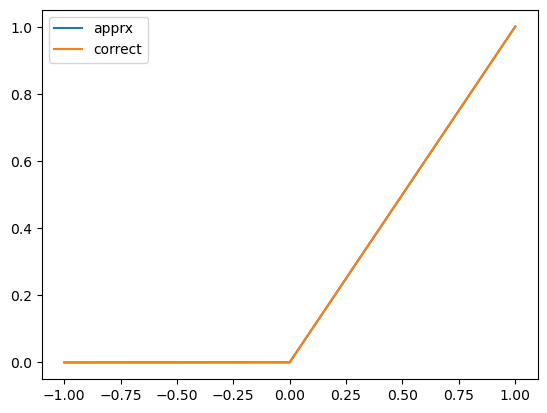

In [9]:
xin = np.linspace(-0.999, 1.001, 100000)

rappx = appr_relu(xin, 12)
rans = relu(xin)

plt.plot(xin, rappx, label="apprx")
plt.plot(xin, rans, label="correct")
plt.legend()
plt.show()